# What is MBTI?
The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use. From scientific or psychological perspective it is based on the work done on cognitive functions by Carl Jung i.e. Jungian Typology.

# Analysis 
Some basic uses could include:
Use machine learning to evaluate the MBTIs validity and ability to predict language styles and behaviour online.
Production of a machine learning algorithm that can attempt to determine a person’s personality type based on some text they have written.

In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [4]:

def clean(text):
    # Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    # remove punctuations 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove any letter contained with numbers
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    # remove '|||'
    text = re.sub('|||', '', text)
    # remove url 
    test = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    return text

clean_comment = lambda x: clean(x)

def preprocess(filename, describe=False):
    # load dataset
    df = pd.read_csv(filename)
    if describe:
        df.describe()
    
    # clean dataset
    df['new_post'] = pd.DataFrame(df.posts.apply(clean_comment))
    df =df[['type','new_post']]
    
    # for simplicity, I will take two types ISFP, ENTJ (seems opposite personality and balanced dataset)
    df = df[df['type'].isin(['ISFP', 'ENTJ'])]
    ISFP=df.loc[df['type']=='ISFP']
    ISFP = ISFP.iloc[40:]
    ENTJ = df.loc[df['type']=='ENTJ']
    df_new=pd.concat([ISFP, ENTJ])
    df_new = shuffle(df_new)
    
    # visualize if they are balanced 
    df_new.loc[df_new['type'] == 'ENTJ', 'new_post'].str.len().apply(np.log1p).hist(label = 'ENTJ', alpha = .5)
    df_new.loc[df_new['type'] == 'ISFP', 'new_post'].str.len().apply(np.log1p).hist(label = 'ISFP', alpha = .5)
    plt.legend();
    
    #Removing Stop Words using NLTK
    
    stop = stopwords.words('english')
    df_new['new_post'] = df_new['new_post'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #Lemmatisating: use Word from textblob to convert all the words to their root form

    df_new['new_post'] = df_new['new_post'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    
    # lets see the most frequent words by wordcloud
    wordcloud = WordCloud(background_color='black',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)
    plt.figure(figsize=(10, 7))
    wordcloud.generate(str(df_new.loc[df_new['type'] == 'ISFP','new_post']))
    plt.imshow(wordcloud);
    plt.title('ISFP')
    plt.axis('off')

    plt.figure(figsize=(10, 7))
    wordcloud.generate(str(df_new.loc[df_new['type'] == 'ENTJ','new_post']))
    plt.imshow(wordcloud);
    plt.title('ENTJ')
    plt.axis('off')
    
    # split dataset into train, valid and test
    n_samples = len(df_new)-1
    n_train = int(0.8*n_samples)
    
    np.random.seed(0)
    random_ids = np.random.permutation(n_samples)
    
    ids_train = random_ids[:n_train]
    df_train = df.iloc[ids_train]
    
    ids_left = random_ids[n_train:]
    ids_val, ids_test = np.array_split(ids_left, 2)
    df_val = df.iloc[ids_val]
    df_test = df.iloc[ids_test]
    
    return df_train, df_val, df_test, df_new

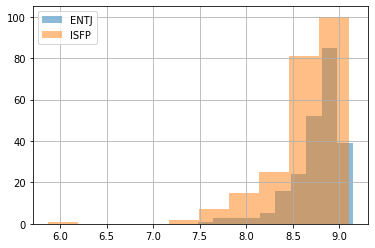

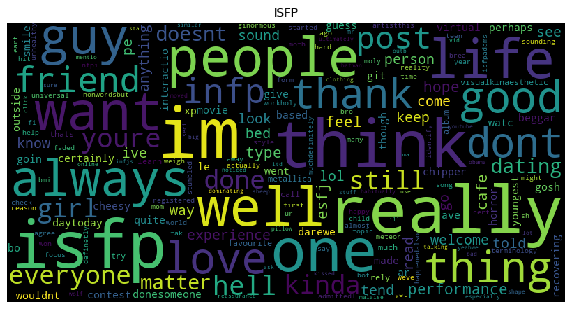

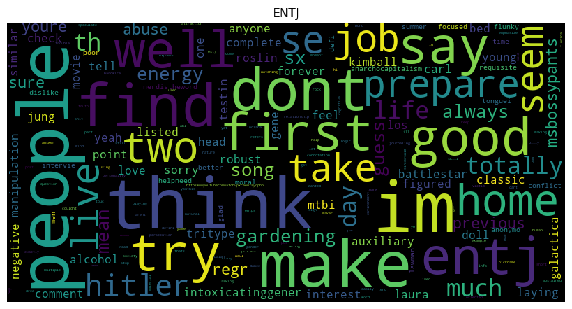

In [5]:
df_train, df_val, df_test, df_new = preprocess('Downloads/mbti_1.csv')

1. From the first graph, we can see that the targets are not balanced
2. Frequent words are presented on WordCloud for each personality but this is not so clear

In [6]:
print('train:', df_train.shape, 'validation:', df_val.shape, 'test:', df_test.shape)

train: (368, 2) validation: (47, 2) test: (46, 2)


In [7]:
# convert the non-numeric data into numeric with label encoder(faster computation)
# ISFP is 1, ENTJ is 0 
# divide in to y_train(target) and X_train(feature)
y_train = LabelEncoder().fit_transform(df_train['type'])
X_train_f = df_train.drop(['type'], axis =1)
y_valid = LabelEncoder().fit_transform(df_val['type'])
X_valid_f = df_val.drop(['type'], axis =1)
y_test = LabelEncoder().fit_transform(df_test['type'])
X_test_f = df_test.drop(['type'], axis =1)

In [8]:
# will use this when we apply the model on test set 
concat_train_val=pd.concat([df_train,df_val])
concat_X_f = concat_train_val.drop(['type'], axis =1)
concat_y = LabelEncoder().fit_transform(concat_train_val['type'])

In [9]:
X_train = X_train_f['new_post'].tolist()
X_valid = X_valid_f['new_post'].tolist()
concat_X = concat_X_f['new_post'].tolist()
X_test = X_test_f['new_post'].tolist()

In [29]:
# Use TfidfTransformer to normalize, meaning we can see how important a word is to a document in a corpus by its frequency

tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.fit_transform(X_valid)

# Lets try Naive Bays, linear SVM, logistic regression, decision tree, and random forest and check accuracy of the each model
# with Validation dataset 
# Lets try Naive Bays, linear SVM, logistic regression, decision tree, and random forest and check accuracy of the each model

multNB = MultinomialNB()
multNB.fit(X_train_tfidf, y_train)

y_pred = multNB.predict(X_valid_tfidf)
accuracy_nb = accuracy_score(y_valid,y_pred)
f1_nb = f1(y_valid,y_pred)
print('1. Multinomial Naive Bayes\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_nb, f1_nb))

print('\n')

svm = SGDClassifier(alpha=0.001, random_state=7, max_iter=20, tol=None)
svm.fit(X_train_tfidf, y_train)
y_pred = svm.predict(X_valid_tfidf)
accuracy_svm = accuracy_score(y_valid,y_pred)
f1_svm = f1(y_valid,y_pred)
print('2. Linear SVM\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_svm,f1_svm))

print('\n')



log = LogisticRegression(C=1)
log.fit(X_train_tfidf, y_train)
y_pred = log.predict(X_valid_tfidf)
accuracy_log = accuracy_score(y_valid,y_pred)
f1_log = f1(y_valid,y_pred)
print('3. Logistic Regression\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_log,f1_log))
print('\n')


tree = DecisionTreeClassifier()
tree.fit(X_train_tfidf, y_train)
y_pred = tree.predict(X_valid_tfidf)
accuracy_tree = accuracy_score(y_valid,y_pred)
f1_tree = f1(y_valid,y_pred)
print('4. Decision Tree\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_tree,f1_tree))

print('\n')

rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_valid_tfidf)
accuracy_rf = accuracy_score(y_valid,y_pred)
f1_rf = f1(y_valid,y_pred)
print('5. Random Forest\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_rf,f1_rf))

1. Multinomial Naive Bayes
accuracy: 0.468
f1_score: 0.490


2. Linear SVM
accuracy: 0.553
f1_score: 0.644


3. Logistic Regression
accuracy: 0.532
f1_score: 0.694


4. Decision Tree
accuracy: 0.489
f1_score: 0.500


5. Random Forest
accuracy: 0.447
f1_score: 0.618


In [11]:
# lets try CountVectorizer and compare it with TfidfVectorizer
# CountVectorizer breaks down texts into words and every row shows a different document(target) and every columns show a different word(tokenize)
# with train dataset 
count_vect = CountVectorizer(analyzer="word")
count_vect.fit(df_new['new_post'])
X_train_cv =  count_vect.transform(X_train)
X_valid_cv =  count_vect.transform(X_valid)

# with validation dataset 

multNB = MultinomialNB()
multNB.fit(X_train_cv, y_train)
y_pred = multNB.predict(X_valid_cv)
accuracy_nb = accuracy_score(y_valid,y_pred)
f1_nb = f1(y_valid,y_pred)
print('1. Multinomial Naive Bayes\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_nb, f1_nb))

print('\n')

svm = SGDClassifier(alpha=0.001, random_state=7, max_iter=20, tol=None)
svm.fit(X_train_cv, y_train)
y_pred = svm.predict(X_valid_cv)
accuracy_svm = accuracy_score(y_valid,y_pred)
f1_svm = f1(y_valid,y_pred)
print('2. Linear SVM\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_svm,f1_svm))

print('\n')
log = LogisticRegression(C=1)
log.fit(X_train_cv, y_train)
y_pred = log.predict(X_valid_cv)
accuracy_log = accuracy_score(y_valid,y_pred)
f1_log = f1(y_valid,y_pred)
print('3. Logistic Regression\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_log,f1_log))
print('\n')


tree = DecisionTreeClassifier()
tree.fit(X_train_cv, y_train)
y_pred = tree.predict(X_valid_cv)
accuracy_tree = accuracy_score(y_valid,y_pred)
f1_tree = f1(y_valid,y_pred)
print('4. Decision Tree\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_tree,f1_tree))

print('\n')

rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train_cv, y_train)
y_pred = rf.predict(X_valid_cv)
accuracy_rf = accuracy_score(y_valid,y_pred)
f1_rf = f1(y_valid,y_pred)
print('5. Random Forest\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_rf,f1_rf))

1. Multinomial Naive Bayes
accuracy: 0.894
f1_score: 0.906


2. Linear SVM
accuracy: 0.936
f1_score: 0.943


3. Logistic Regression
accuracy: 0.936
f1_score: 0.941


4. Decision Tree
accuracy: 0.872
f1_score: 0.880


5. Random Forest
accuracy: 0.872
f1_score: 0.885



1. As for this data, count vector brings better outcome than TF-IDF. 
2. Also, Logistic Regression and Linear SVM shows the best accuracy compared to the the rest three models.
3. Lets use count vector & Logistics Regression & Linear SVM for the test set 

In [26]:
# concat train+valid and use it for test dataset
count_vect = CountVectorizer(analyzer="word")
count_vect.fit(df_new['new_post'])
X_train_val_cv =  count_vect.transform(concat_X)
X_test_cv =  count_vect.transform(X_test)

log = LogisticRegression(C=1)
log.fit(X_train_val_cv, concat_y)
y_pred = log.predict(X_test_cv)
accuracy_log = accuracy_score(y_test,y_pred)
f1_log = f1(y_test,y_pred)
print('1. Logistic Regression\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_log,f1_log))


print('\n')

svm = SGDClassifier(alpha=0.001, random_state=7, max_iter=20, tol=None)
svm.fit(X_train_val_cv, concat_y)
y_pred = svm.predict(X_test_cv)
accuracy_svm = accuracy_score(y_test,y_pred)
f1_svm = f1(y_test,y_pred)
print('2. Linear SVM\naccuracy: %.3f\nf1_score: %.3f' 
      %(accuracy_svm,f1_svm))



1. Logistic Regression
accuracy: 0.913
f1_score: 0.917


2. Linear SVM
accuracy: 0.913
f1_score: 0.917



# Conclusion
1. Test result shows lower accuracy than train set.
2. Due to small dataset, there is chance for overfitting. This can be investigated by looing at the gap of accuracy between train and validation
3. After that, try the whole process several times with different random train, val and test and compare accuracy on test set.
4. To be continued..
